In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [4]:
%matplotlib notebook

In [5]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


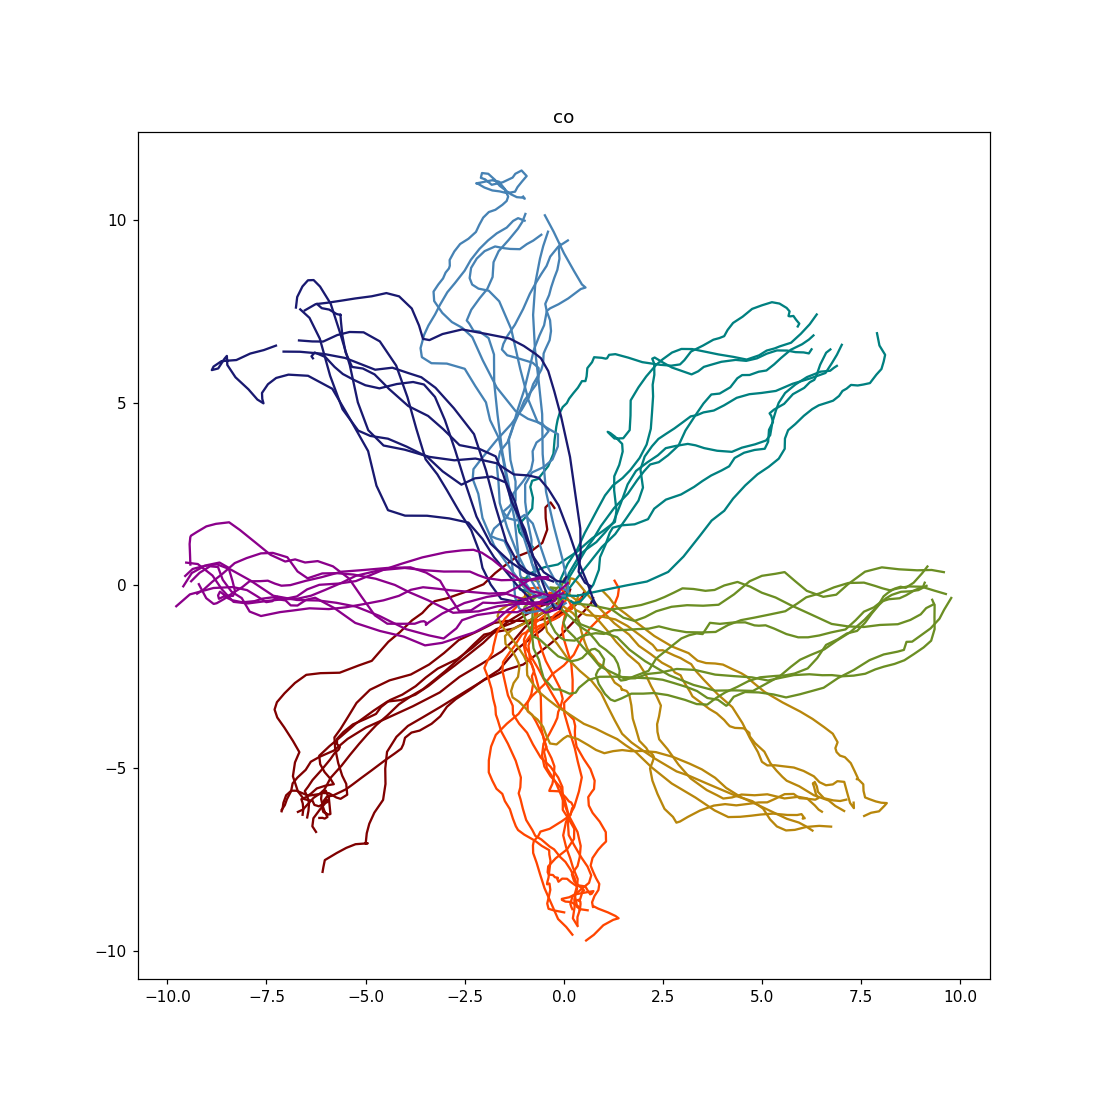

<IPython.core.display.Javascript object>


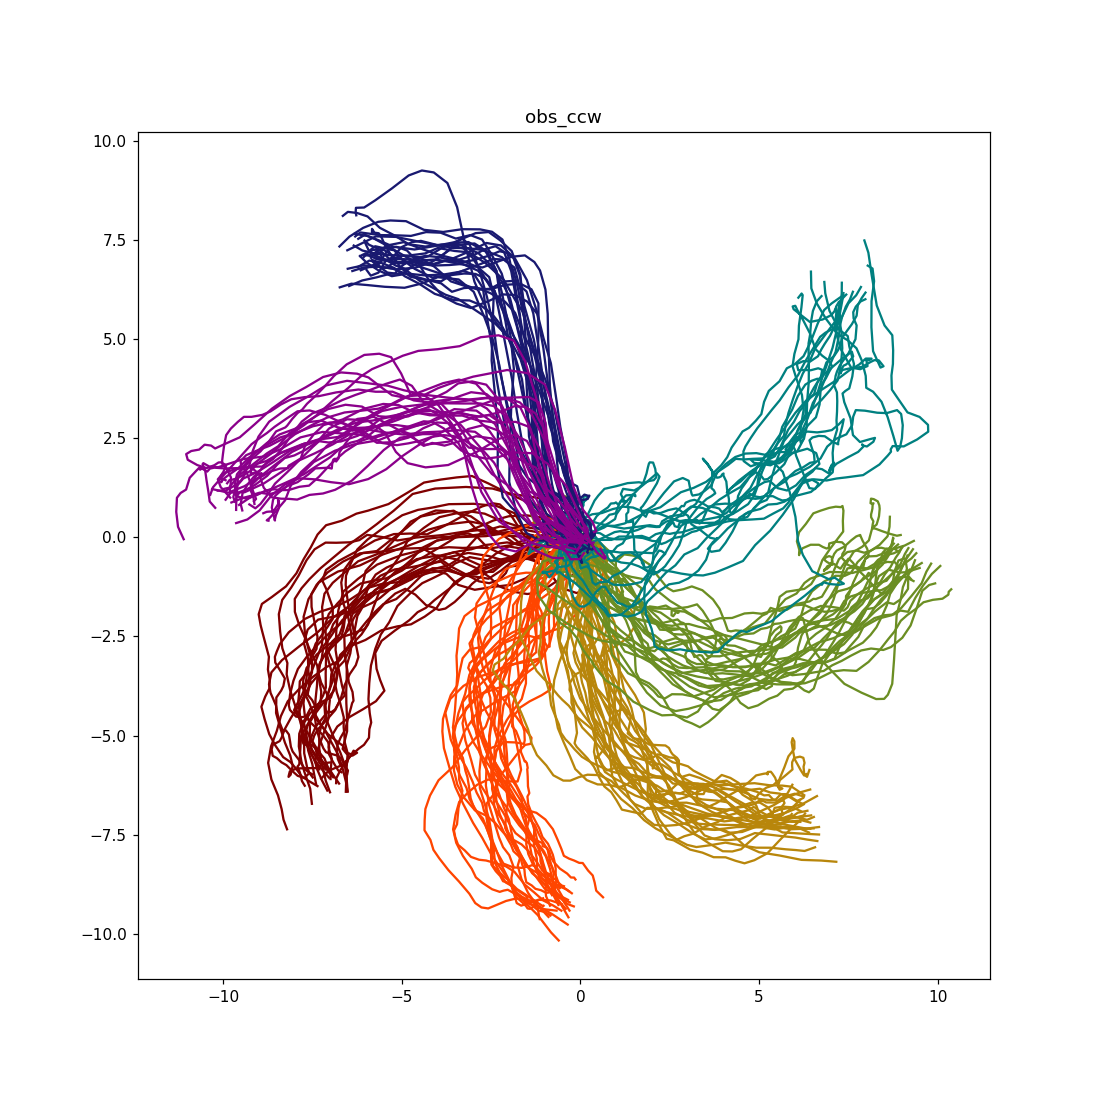

<IPython.core.display.Javascript object>


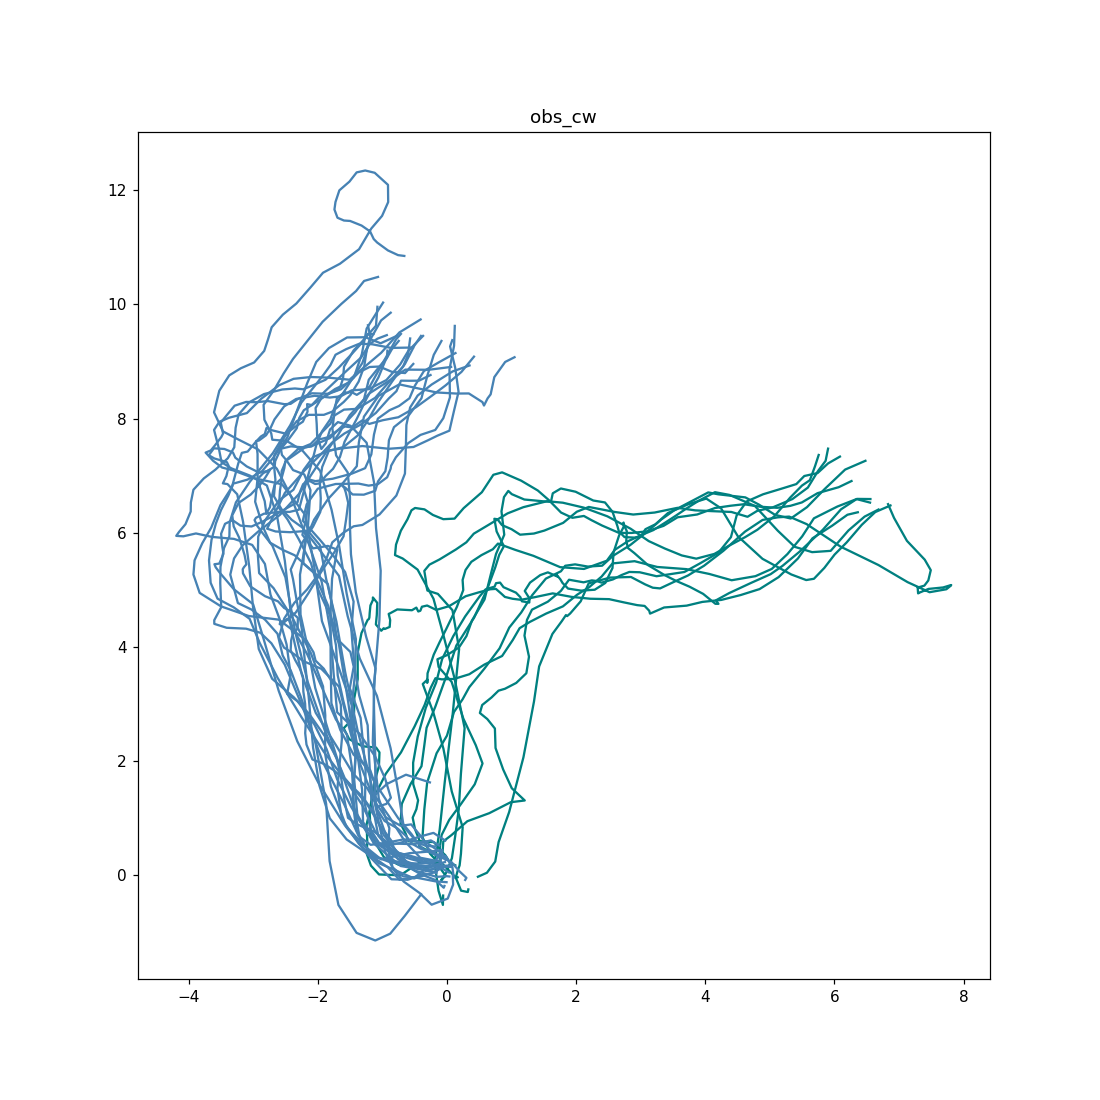

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)
                

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


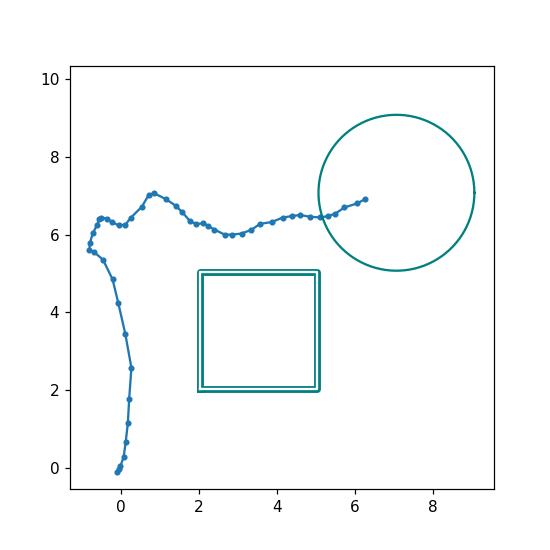

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [7]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

In [14]:
#LOAD:

load_decoder_null = True
a = 'grom'
d = str(0)

if load_decoder_null:
    save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_sim_Q2_decoder_null.pkl')
else:
    save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_sim_Q2_full.pkl')

with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')

In [9]:
r.keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

In [10]:
df_lqr_n.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,u_p_angle,u_v_mag,u_v_angle,u_v_mag_bin,u_v_angle_bin,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin
0,0.672167,0.352830,-0.195437,-0.037406,0.682054,1.771170,0.991923,0.282416,0.311419,-0.163516,...,1.681725,8.401967e-15,1.685795,0.0,5.0,0.000000,0.000000,-4.601460,-4.597390,1.685795
1,0.467409,0.287225,0.389544,0.140978,1.000296,2.152551,1.721297,-0.135388,-0.391284,0.332112,...,-2.406005,1.319497e+00,-2.406005,1.0,0.0,-0.581557,-0.581557,-2.406005,-2.406005,-2.406005
2,0.778749,0.133178,0.404584,0.263752,1.190420,2.236899,0.931310,-0.229430,-0.473472,0.558034,...,-2.251693,1.334684e+00,-2.251693,1.0,0.0,-1.966663,-2.163205,-2.251693,-2.251693,-2.251693
3,1.362344,0.394493,0.438020,0.501505,1.114690,1.484939,0.971405,0.034816,-0.939386,-0.317849,...,-2.554200,1.526276e+00,-2.554200,1.0,0.0,-2.064177,-2.115658,-2.554200,-2.554200,-2.554200
4,1.708029,0.669980,0.835890,0.401787,0.977282,2.203376,0.996696,0.074546,-0.603533,0.123265,...,-2.405852,1.459470e+00,-2.405852,1.0,0.0,-2.156420,-2.297614,-2.405852,-2.405852,-2.405852


In [13]:
list(df_lqr_n.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [23]:
range(3)

[0, 1, 2]

#### Decoder space projections

In [166]:
Kn.shape

(5L, 44L)

In [167]:
#Decoder projections
decoder_rank = 2
mat = Kn.T #num_cursor_var X num_neurons #decoder_dic[a,d,'KG'].T
u,s,vh = np.linalg.svd(mat)
decoder_space = np.mat(u[:,:decoder_rank])
decoder_proj = decoder_space*decoder_space.T#np.matmul(decoder_space, decoder_space.T)

decoder_null_space = u[:,decoder_rank:]
decoder_null_proj = np.eye(decoder_proj.shape[0])-decoder_proj

#### Confirm binning of commands

<IPython.core.display.Javascript object>


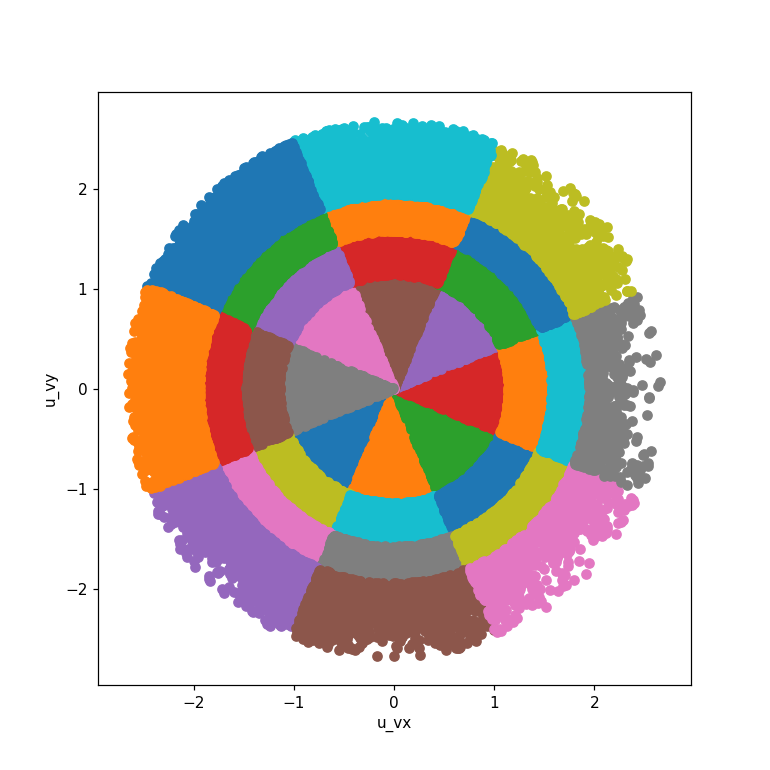

Text(0,0.5,'u_vy')

In [28]:
#Plot commands in a bin: 
num_mag_bins_analyze = 4
num_angle_bins = 8

plt.figure(figsize=(7,7))
for mag_bin in range(num_mag_bins_analyze):
    for angle_bin in range(num_angle_bins):
        sel_mag = df_lqr_n['u_v_mag_bin']==mag_bin
        sel_angle = df_lqr_n['u_v_angle_bin']==angle_bin
        sel = sel_mag&sel_angle
        d_c = df_lqr_n[sel][['u_vx', 'u_vy']]

        plt.scatter(d_c['u_vx'], d_c['u_vy'])
plt.axis('square')
plt.xlabel('u_vx')
plt.ylabel('u_vy')

In [35]:
df_lqr_n.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,u_p_angle,u_v_mag,u_v_angle,u_v_mag_bin,u_v_angle_bin,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin
0,0.672167,0.352830,-0.195437,-0.037406,0.682054,1.771170,0.991923,0.282416,0.311419,-0.163516,...,1.681725,8.401967e-15,1.685795,0.0,5.0,0.000000,0.000000,-4.601460,-4.597390,1.685795
1,0.467409,0.287225,0.389544,0.140978,1.000296,2.152551,1.721297,-0.135388,-0.391284,0.332112,...,-2.406005,1.319497e+00,-2.406005,1.0,0.0,-0.581557,-0.581557,-2.406005,-2.406005,-2.406005
2,0.778749,0.133178,0.404584,0.263752,1.190420,2.236899,0.931310,-0.229430,-0.473472,0.558034,...,-2.251693,1.334684e+00,-2.251693,1.0,0.0,-1.966663,-2.163205,-2.251693,-2.251693,-2.251693
3,1.362344,0.394493,0.438020,0.501505,1.114690,1.484939,0.971405,0.034816,-0.939386,-0.317849,...,-2.554200,1.526276e+00,-2.554200,1.0,0.0,-2.064177,-2.115658,-2.554200,-2.554200,-2.554200
4,1.708029,0.669980,0.835890,0.401787,0.977282,2.203376,0.996696,0.074546,-0.603533,0.123265,...,-2.405852,1.459470e+00,-2.405852,1.0,0.0,-2.156420,-2.297614,-2.405852,-2.405852,-2.405852


In [41]:
r.keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

In [42]:
list(df_lqr_n.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [82]:
df_lqr_n[n_list+u_list+['model']].head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_40,n_41,n_42,n_43,u_px,u_py,u_vx,u_vy,u_offset,model
0,0.672167,0.352830,-0.195437,-0.037406,0.682054,1.771170,0.991923,0.282416,0.311419,-0.163516,...,0.918332,0.959449,0.486522,1.099839,-9.277766e-17,8.329398e-16,-9.640856e-16,8.346471e-15,0.0,n_do
1,0.467409,0.287225,0.389544,0.140978,1.000296,2.152551,1.721297,-0.135388,-0.391284,0.332112,...,0.750413,2.072327,0.647550,1.161383,-9.783233e-02,-8.854124e-02,-9.783233e-01,-8.854124e-01,0.0,n_do
2,0.778749,0.133178,0.404584,0.263752,1.190420,2.236899,0.931310,-0.229430,-0.473472,0.558034,...,0.829748,2.299750,0.904145,1.656954,-8.401704e-02,-1.037061e-01,-8.401704e-01,-1.037061e+00,0.0,n_do
3,1.362344,0.394493,0.438020,0.501505,1.114690,1.484939,0.971405,0.034816,-0.939386,-0.317849,...,0.760395,2.882247,1.097286,1.174223,-1.270455e-01,-8.458505e-02,-1.270455e+00,-8.458505e-01,0.0,n_do
4,1.708029,0.669980,0.835890,0.401787,0.977282,2.203376,0.996696,0.074546,-0.603533,0.123265,...,0.681686,2.935525,1.080780,0.906236,-1.081954e-01,-9.795030e-02,-1.081954e+00,-9.795030e-01,0.0,n_do


#### Reconstruct command

In [86]:
#Reconstruct command: 
Kn_mat = np.mat(Kn)

#Choose a time sample
i = 1700
n_df = df_lqr_n.iloc[i][n_list]
n_mat = np.mat(n_df).T

u_list = ['u_px','u_py','u_vx','u_vy','u_offset']
u_df = df_lqr_n.iloc[i][u_list]
u_mat = np.mat(u_df).T
print('saved command')
print(u_mat) 

#Reconstruct command 'u_mat'
u_mat_recon = Kn_mat*n_mat
u_mat_recon.shape
print('recon command')
print(u_mat_recon)

saved command
[[-0.12409221640744199]
 [-0.07525965880427744]
 [-1.2409221640744268]
 [-0.7525965880427786]
 [0.0]]
recon command
[[-0.12409221640744199]
 [-0.07525965880427746]
 [-1.240922164074427]
 [-0.7525965880427786]
 [0.0]]


#### Confirm noise level

In [87]:
list(df_lqr_n.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [ ]:
r.keys()

In [29]:
A_list

['n_do', 'n_o', 'n_null', 'n_d', 'n_decoder_null']

In [31]:
A_dic.keys()

['n_null', 'n_d', 'n_do', 'n_o']

In [32]:
Kn.shape

(5L, 44L)

In [91]:
move_lqr_n[(3, 1.2, 'n_do')].keys()

['A',
 'Q_f',
 'sim_len',
 'B',
 'K_list',
 'move_len',
 'state_noise_list',
 'state_e_list',
 'Q',
 'R',
 'u_list',
 'state_init',
 'horizon_list',
 'state_list',
 'A_e_list',
 'state_T_list']

('condition', 0, 0)


<IPython.core.display.Javascript object>


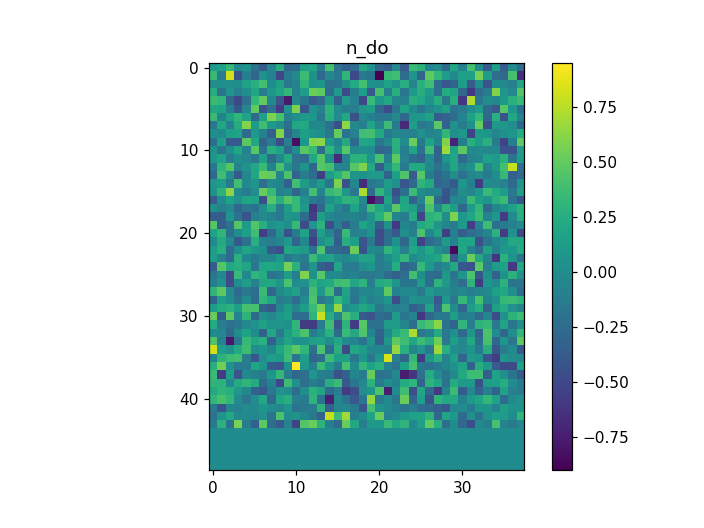

<IPython.core.display.Javascript object>


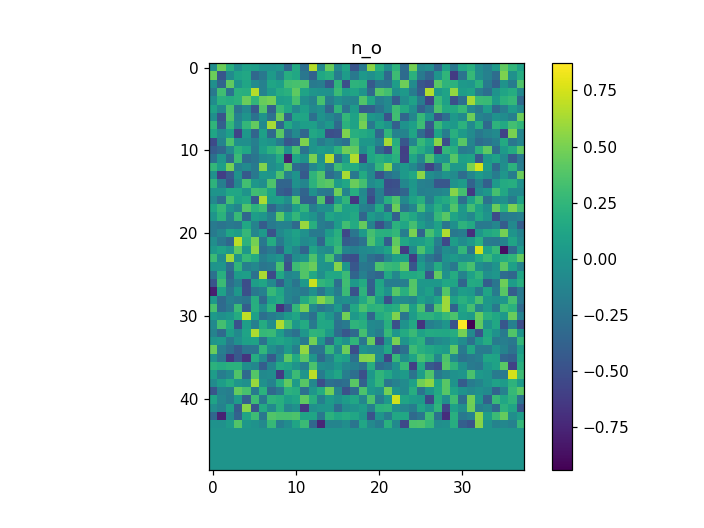

Text(0.5,1,'n_o')

In [113]:
#Inspect the noise level
#NOTE: the state_noise_list had a bug in saving, i only have one trial of the noise.
target = 0
task_rot = 0

print('condition', target, task_rot)

m = 'n_do'
noise_ex = move_lqr_n[(target, task_rot, m)]['state_noise_list']
plt.figure()
plt.imshow(noise_ex)
plt.colorbar()
plt.title(m)

m = 'n_o'
noise_ex = move_lqr_n[(target, task_rot, m)]['state_noise_list']
plt.figure()
plt.imshow(noise_ex)
plt.colorbar()
plt.title(m)


#### check how much decoder-null, decoder-potent variance there is

In [432]:
print('decoder null variance')
for m in ['n_do', 'n_o']:
    sel_m = df_lqr_n['model']==m
    n_mat = np.mat(df_lqr_n[sel_m][n_list]).T
    n_null = decoder_null_proj*n_mat
    null_var = np.trace(np.cov(n_null))
    print(m, null_var)

decoder null variance
('n_do', 4.334121593125433)
('n_o', 3.0794341217978625)


In [433]:
print('decoder potent variance')
for m in ['n_do', 'n_o']:
    sel_m = df_lqr_n['model']==m
    n_mat = np.mat(df_lqr_n[sel_m][n_list]).T
    n_potent = decoder_proj*n_mat
    potent_var = np.trace(np.cov(n_potent))
    print(m, potent_var)

decoder potent variance
('n_do', 3.4881065380047676)
('n_o', 3.479852480386397)


#### check inputs to neurons do not enter decoder-null space

In [434]:
num_neurons

44L

In [436]:
input_list = ['u_'+str(i) for i in range(num_neurons)]
input_list

['u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43']

In [437]:
print('decoder null variance of inputs')
for m in ['n_do', 'n_o']:
    sel_m = df_lqr_n['model']==m
    u_mat = np.mat(df_lqr_n[sel_m][input_list]).T
    u_null = decoder_null_proj*u_mat
    null_var = np.trace(np.cov(u_null))
    print(m, null_var)

decoder null variance
('n_do', 6.045297717238697e-28)
('n_o', 5.055202599840998e-28)


In [439]:
print('decoder potent variance of inputs')
for m in ['n_do', 'n_o']:
    sel_m = df_lqr_n['model']==m
    u_mat = np.mat(df_lqr_n[sel_m][input_list]).T
    u_potent = decoder_proj*u_mat
    potent_var = np.trace(np.cov(u_potent))
    print(m, potent_var)

decoder potent variance of inputs
('n_do', 3.3376610745772526)
('n_o', 3.3291802170933096)


#### compare two conditions for the same command

In [ ]:
#TODO:

#### poor man's matching

In [114]:
list(df_lqr_n.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [116]:
task_rot_list

[0, 1.1, 1.2]

In [137]:
np.sum(sel)

97

In [186]:
idx_arr = np.array(df_lqr_n[sel].index)


array([73327, 73328, 73329, 73333, 73334, 73335, 73360, 73362, 73369,
       73373, 73374, 73400, 73404, 73407, 73409, 73413, 73438, 73439,
       73440, 73444, 73452, 73485, 73491, 73517, 73519, 73520, 73528,
       73529, 73530, 73556, 73562, 73567, 73568, 73569, 73594, 73596,
       73598, 73603, 73604, 73607, 73634, 73637, 73645, 73646, 73647,
       73680, 73682, 73683, 73684, 73686, 73719, 73720, 73725, 73750,
       73752, 73754, 73758, 73762, 73763, 73764, 73793, 73797, 73802,
       73803, 73829, 73834, 73836, 73839, 73867, 73871, 73876, 73879,
       73880, 73881, 73911, 73916, 73918, 73920, 73921, 73946, 73956,
       73957, 73959, 73960, 73990, 73992, 73993, 73998, 74031, 74035,
       74036, 74037, 74066, 74069, 74074, 74075, 74076], dtype=int64)

In [185]:
df_lqr_n.iloc[idx_list[1]]

n_0                    0.423072
n_1                  -0.0850732
n_2                    0.600786
n_3                   -0.212625
n_4                    0.681604
n_5                     1.73699
n_6                     1.40018
n_7                   -0.054985
n_8                   -0.930637
n_9                    0.268571
n_10                   0.804673
n_11                    1.89055
n_12                 -0.0227117
n_13                   -0.23557
n_14                   0.664904
n_15                     1.5517
n_16                  -0.393037
n_17                    0.70226
n_18                    1.23544
n_19                   0.981742
n_20                   0.381051
n_21                    1.50489
n_22                    0.92926
n_23                    1.49314
n_24                   0.342739
n_25                   0.890676
n_26                   0.522373
n_27                    1.43123
n_28                   0.362509
n_29                   0.535942
                        ...    
u_35    

<IPython.core.display.Javascript object>


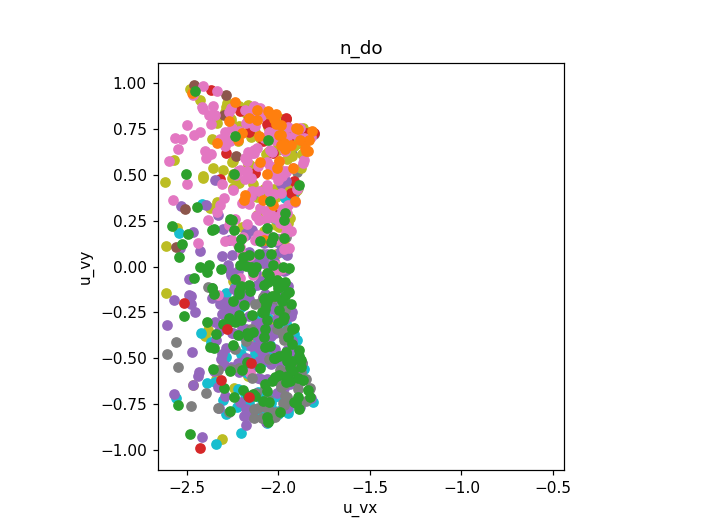

<IPython.core.display.Javascript object>


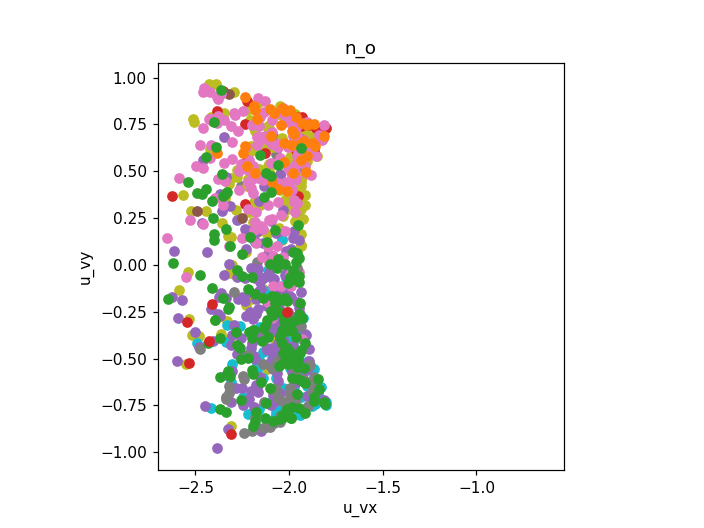

In [544]:
#Pick a command

nc = {}

mag_bin = 3
angle_bin = 7

sel_mag = df_lqr_n['u_v_mag_bin']==mag_bin
sel_angle = df_lqr_n['u_v_angle_bin']==angle_bin

#Plot for all movements: 
m_list = ['n_do', 'n_o']
for m in m_list:
    sel_m = df_lqr_n['model']==m
    
    sel = sel_mag&sel_angle&sel_m
    nc[m, 'sel_idxs'] = np.array(df_lqr_n[sel].index)
    
    nc[m, 'n'] = df_lqr_n[sel][n_list]
    nc[m, 'c'] = df_lqr_n[sel][['u_vx', 'u_vy']]

    plt.figure()
    plt.title(m)
    for task_rot in task_rot_list:
        sel_task = df_lqr_n['task_rot']==task_rot
        for target in range(num_targets):
            sel_target = df_lqr_n['target']==target

            sel = \
            sel_m &\
            sel_mag &\
            sel_angle &\
            sel_task &\
            sel_target
            
            num = np.sum(sel)
            d_c = df_lqr_n[sel][['u_vx', 'u_vy']]
            d_n = df_lqr_n[sel][n_list]
            
            nc[m, target, task_rot, 'num'] = num
            nc[m, target, task_rot, 'n'] = d_n
            nc[m, target, task_rot, 'c'] = d_c

            plt.scatter(d_c['u_vx'], d_c['u_vy'], label=(task_rot,target))
    plt.axis('square')
    plt.xlabel('u_vx')
    plt.ylabel('u_vy')
    

# plt.xlim([-3, 3])
# plt.ylim([-3, 3])
# plt.legend()

In [547]:
for m in m_list:
    for dt in ['n', 'c']:
        mat = np.mat(nc[m, dt]).T
        mean = np.mean(mat,axis=1)
        nc[m, dt, 'mean'] = mean


In [548]:
nc['n_do', 'n', 'mean'].shape

(44L, 1L)

In [549]:
#Calculate distances
proj_list = ['full', 'potent', 'null']

min_num = 10
for m in m_list:
    for task_rot in task_rot_list:
        for target in range(num_targets):
            num = nc[m, target, task_rot, 'num']
            if num >= min_num:
                for dt in ['n', 'c']:
                    mat = np.mat(nc[m, target, task_rot, dt]).T
                    nc[m, target, task_rot, dt, 'mean'] = np.mean(mat, axis=1)
                    diff = nc[m, target, task_rot, dt, 'mean']-nc[m, dt, 'mean']
                    nc[m, target, task_rot, dt, 'diff', 'full'] = diff
                    if dt == 'n':
                        print(m, target, task_rot)
                        nc[m, target, task_rot, dt, 'diff', 'null'] = np.dot(decoder_null_proj, diff)
                        nc[m, target, task_rot, dt, 'diff', 'potent'] = np.dot(decoder_proj, diff)

                        for proj in proj_list:
                            diff = nc[m, target, task_rot, dt, 'diff', proj] 
                            nc[m, target, task_rot, dt, 'dist', proj] = np.linalg.norm(diff)
            

('n_do', 7, 0)
('n_do', 0, 1.1)
('n_do', 1, 1.1)
('n_do', 5, 1.1)
('n_do', 6, 1.1)
('n_do', 0, 1.2)
('n_do', 1, 1.2)
('n_do', 5, 1.2)
('n_do', 6, 1.2)
('n_o', 7, 0)
('n_o', 0, 1.1)
('n_o', 1, 1.1)
('n_o', 5, 1.1)
('n_o', 6, 1.1)
('n_o', 0, 1.2)
('n_o', 1, 1.2)
('n_o', 5, 1.2)
('n_o', 6, 1.2)


In [550]:
for m in m_list:
    nc[m, 'cond_list'] = []
    nc[m, 'cond_num_list'] = []
    
    for task_rot in task_rot_list:
        for target in range(num_targets):
            num = nc[m, target, task_rot, 'num']
            if num >= min_num:
                nc[m, 'cond_list'].append((target, task_rot))
                nc[m, 'cond_num_list'].append(num)

In [551]:
for m in m_list: 
    print(m)
    #print(nc[m, 'cond_list'])
    for i,cond in enumerate(nc[m, 'cond_list']):
        target = cond[0]
        task_rot = cond[1]
        dist = nc[m, target, task_rot, 'n', 'dist', 'null']
        print(dist, nc[m, 'cond_num_list'][i])
    print('')

n_do
(0.4471147278997131, 15)
(0.2842530724523891, 117)
(0.5557506954475809, 83)
(0.4623423528479619, 21)
(0.36175961808491036, 178)
(0.35749368777909335, 150)
(0.32845221761985705, 63)
(0.5547574713461894, 42)
(0.30439489636726036, 156)

n_o
(0.44926222284480755, 16)
(0.1550734433371879, 123)
(0.1743971004439397, 92)
(0.37544228319767226, 22)
(0.12208319773480915, 175)
(0.11386750762437442, 151)
(0.2620676387935848, 52)
(0.23923473274139193, 39)
(0.12320495624376544, 149)



In [552]:
m = 'n_do'


i = 2
cond = nc[m, 'cond_list'][i]
target = cond[0]
task_rot = cond[1]
num_obs = nc[m, 'cond_num_list'][i]
mean_cond = nc[m, target, task_rot, 'n', 'mean'] 
diff_cond = nc[m, target, task_rot, 'n', 'diff', 'full'] 
diff_null_cond = nc[m, target, task_rot, 'n', 'diff', 'null'] 

dist_cond = nc[m, target, task_rot, 'n', 'dist', 'full'] 
dist_null_cond = nc[m, target, task_rot, 'n', 'dist', 'null']
print(cond)
print(num_obs)

(1, 1.1)
83


In [553]:
len(nc[m, 'sel_idxs'])

838

In [554]:
sel_idxs = nc[m, 'sel_idxs']
rand_idxs = np.random.choice(sel_idxs,num_obs,replace=False)

In [555]:
sel_idxs

array([ 3121,  3122,  3128,  3130,  3131,  3135,  3160,  3165,  3168,
        3171,  3172,  3173,  3174,  3206,  3209,  3213,  3247,  3250,
        3251,  3252,  3280,  3284,  3285,  3289,  3291,  3320,  3325,
        3327,  3328,  3329,  3330,  3360,  3361,  3364,  3365,  3366,
        3367,  3370,  3395,  3400,  3402,  3404,  3409,  3433,  3434,
        3435,  3438,  3440,  3441,  3443,  3446,  3447,  3448,  3477,
        3478,  3481,  3482,  3485,  3486,  3511,  3512,  3513,  3517,
        3521,  3524,  3525,  3526,  3552,  3556,  3559,  3560,  3561,
        3563,  3592,  3595,  3596,  3597,  3599,  3632,  3636,  3642,
        3643,  3675,  3677,  3681,  3682,  3710,  3711,  3713,  3716,
        3717,  3719,  3720,  3745,  3747,  3759,  3784,  3785,  3786,
        3790,  3791,  3794,  3797,  3798,  3825,  3826,  3827,  3835,
        3836,  3838,  3862,  3863,  3864,  3870,  3873,  3875,  3876,
        6260,  6261,  6262,  6264,  6266,  6270,  6271,  6302,  6304,
        6307,  6308,

In [556]:
rand_idxs

array([ 6585,  6418,  6699, 62638, 49942,  6893,  6340, 62765, 53393,
       59346, 13186, 12481, 59621, 66113, 53244,  6768,  3171,  3643,
       12566,  6884,  3438,  7003,  6343, 59930, 60015,  3559, 16245,
        6774, 62560, 62531, 62725, 59697, 63029, 53630, 59546, 62754,
        6307,  3560,  6458, 59737, 65704, 65679, 12911, 13154, 59887,
       62414, 59342,  6650, 62916, 59742, 63112, 50142, 59931, 62917,
       63078, 13028,  3122, 59854,  6966, 59389,  6494, 16092, 62443,
        6536,  7014, 59928, 13228,  7002, 62839, 59428,  6574, 62482,
       62995,  6849,  3798,  6425,  3597, 59890, 13039, 12520, 62991,
       59970, 16288], dtype=int64)

In [557]:
df_lqr_n.iloc[rand_idxs][['model', 'u_v_mag_bin', 'u_v_angle_bin', 'task_rot', 'target']]

,model,u_v_mag_bin,u_v_angle_bin,task_rot,target
6585,n_do,3.0,7.0,1.2,0
6418,n_do,3.0,7.0,1.2,0
6699,n_do,3.0,7.0,1.2,0
62638,n_do,3.0,7.0,1.2,6
49942,n_do,3.0,7.0,1.1,5
6893,n_do,3.0,7.0,1.2,0
6340,n_do,3.0,7.0,1.2,0
62765,n_do,3.0,7.0,1.2,6
53393,n_do,3.0,7.0,1.2,5
59346,n_do,3.0,7.0,1.1,6


In [558]:
#Select the activity: 
df_sel = df_lqr_n.iloc[rand_idxs][n_list]
mat_sel = np.mat(df_sel)

In [559]:
df_sel

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_34,n_35,n_36,n_37,n_38,n_39,n_40,n_41,n_42,n_43
6585,1.294951,0.264786,0.806610,0.526803,1.375635,2.821268,1.682979,-0.229223,0.083947,-0.383099,...,0.491594,1.207006,3.652827,2.890971,3.661591,1.583354,0.868149,2.863802,0.297650,1.106443
6418,1.634167,0.181236,0.923684,0.919386,1.105580,1.914548,1.318199,-0.086693,0.290179,-0.096265,...,0.778242,1.249704,4.000130,2.002930,3.985577,2.146950,0.632425,2.580487,0.177324,0.830546
6699,1.032193,-0.011854,0.666936,0.551573,1.770294,2.347336,1.121743,0.254547,0.279405,0.024795,...,1.202827,1.100547,4.088848,3.139008,4.441210,1.731667,0.700437,3.142619,0.699499,1.305912
62638,1.513307,0.175248,0.904043,0.704794,1.376206,2.296759,1.250007,0.246718,0.129073,-0.115187,...,0.775387,1.185141,3.067576,1.743289,3.274911,2.054767,0.890601,2.168968,0.940112,1.483656
49942,1.076690,0.584233,1.228696,0.452599,1.584526,2.283835,1.244711,0.012110,0.145136,-0.148747,...,0.041321,1.151244,3.254581,2.285522,3.774240,1.680302,0.843791,2.610688,0.757721,1.491833
6893,1.386904,0.379739,0.833605,0.599239,1.106740,2.743498,2.043678,0.173521,-0.167559,0.046544,...,1.333749,0.978966,3.430342,2.550507,3.353999,1.185624,0.464149,3.434334,0.302009,0.876134
6340,0.790654,-0.006187,0.580497,0.301855,1.299673,2.599843,1.630987,0.180590,0.231740,-0.221382,...,1.035701,1.043151,3.001506,2.852320,3.725357,1.586003,0.725297,2.684378,0.335646,0.905375
62765,1.129108,0.689745,0.989620,0.641911,1.381054,2.475888,0.991266,0.038280,-0.421169,0.130595,...,0.884961,1.157825,2.778912,2.097782,3.531173,1.154496,0.727199,3.276323,-0.083329,0.532095
53393,1.268334,0.201394,0.891538,0.769224,1.814929,2.603475,1.419406,-0.295708,0.280725,-0.437922,...,0.922050,0.984071,2.389191,2.020358,2.810517,1.664674,0.939280,2.486470,1.022236,1.148166
59346,1.388625,0.483723,1.249993,0.518569,1.666143,2.269164,1.331501,0.270777,-0.476126,-0.232181,...,1.469143,1.593559,3.710123,2.631073,3.425422,1.898042,0.972005,2.941830,0.658381,1.275224


In [560]:
mat_sel.shape

(83L, 44L)

In [561]:
mean_sel = np.mean(mat_sel,axis=0).T
mean_sel

matrix([[ 1.2080921 ],
        [ 0.33187954],
        [ 0.92501996],
        [ 0.61314374],
        [ 1.41296861],
        [ 2.36828812],
        [ 1.43315246],
        [ 0.10128294],
        [-0.0440485 ],
        [-0.17260838],
        [ 0.77400727],
        [ 2.01952352],
        [ 0.02788533],
        [ 0.07621951],
        [ 1.04871866],
        [ 1.91554341],
        [ 0.25800096],
        [ 0.63011092],
        [ 1.00161087],
        [ 0.76705076],
        [ 0.50371119],
        [ 1.5747073 ],
        [ 1.22204224],
        [ 1.68713564],
        [ 0.78998602],
        [ 0.42388827],
        [ 1.30996369],
        [ 1.77824966],
        [ 0.89829876],
        [ 0.62786906],
        [ 1.38741788],
        [ 1.95049681],
        [ 1.63617029],
        [ 0.9810517 ],
        [ 0.91699938],
        [ 1.31708305],
        [ 3.25700338],
        [ 2.41446448],
        [ 3.43422957],
        [ 1.80432108],
        [ 0.85315116],
        [ 2.83066286],
        [ 0.51540688],
        [ 1

In [562]:
nc[m, 'n', 'mean']

matrix([[ 1.23507532],
        [ 0.33193379],
        [ 1.00428137],
        [ 0.63381231],
        [ 1.40889167],
        [ 2.33021313],
        [ 1.48197123],
        [ 0.07809752],
        [-0.03350766],
        [-0.19044225],
        [ 0.73826076],
        [ 2.00276284],
        [ 0.04088682],
        [ 0.09243712],
        [ 1.01950917],
        [ 1.91093708],
        [ 0.2515583 ],
        [ 0.59431426],
        [ 1.02446616],
        [ 0.74667901],
        [ 0.50321533],
        [ 1.56355635],
        [ 1.28938321],
        [ 1.67118386],
        [ 0.75640356],
        [ 0.41173001],
        [ 1.29257999],
        [ 1.7626084 ],
        [ 0.87381837],
        [ 0.66062327],
        [ 1.34381252],
        [ 1.97760974],
        [ 1.60123669],
        [ 0.96663597],
        [ 0.9196502 ],
        [ 1.28164193],
        [ 3.27514271],
        [ 2.41826321],
        [ 3.4077554 ],
        [ 1.78469407],
        [ 0.89230976],
        [ 2.81848587],
        [ 0.52845809],
        [ 1

In [563]:
mean_cond

matrix([[ 1.18015696],
        [ 0.31321413],
        [ 1.12085171],
        [ 0.56137524],
        [ 1.39411526],
        [ 2.35463674],
        [ 1.49277997],
        [ 0.07573348],
        [-0.22009643],
        [-0.09219398],
        [ 0.72606692],
        [ 1.9910305 ],
        [ 0.03067687],
        [ 0.06978467],
        [ 1.03021282],
        [ 1.91795193],
        [ 0.1976085 ],
        [ 0.61207435],
        [ 1.04269878],
        [ 0.75627289],
        [ 0.50870718],
        [ 1.56960387],
        [ 1.27319834],
        [ 1.67250715],
        [ 0.6971467 ],
        [ 0.4071927 ],
        [ 1.28418061],
        [ 1.70936845],
        [ 0.90612401],
        [ 0.6628888 ],
        [ 1.32380763],
        [ 1.9830881 ],
        [ 1.57643588],
        [ 0.99439724],
        [ 0.89528076],
        [ 1.30532981],
        [ 3.03000492],
        [ 2.17713434],
        [ 2.91551595],
        [ 1.75586016],
        [ 0.91273633],
        [ 2.70967297],
        [ 0.54278989],
        [ 1

In [564]:
diff_sel = mean_sel-nc[m, 'n', 'mean']
diff_sel

matrix([[-2.69832203e-02],
        [-5.42496904e-05],
        [-7.92614103e-02],
        [-2.06685681e-02],
        [ 4.07694317e-03],
        [ 3.80749898e-02],
        [-4.88187701e-02],
        [ 2.31854214e-02],
        [-1.05408489e-02],
        [ 1.78338746e-02],
        [ 3.57465048e-02],
        [ 1.67606805e-02],
        [-1.30014919e-02],
        [-1.62176125e-02],
        [ 2.92094836e-02],
        [ 4.60632398e-03],
        [ 6.44266138e-03],
        [ 3.57966569e-02],
        [-2.28552907e-02],
        [ 2.03717535e-02],
        [ 4.95854147e-04],
        [ 1.11509443e-02],
        [-6.73409673e-02],
        [ 1.59517798e-02],
        [ 3.35824552e-02],
        [ 1.21582582e-02],
        [ 1.73836982e-02],
        [ 1.56412693e-02],
        [ 2.44803908e-02],
        [-3.27542114e-02],
        [ 4.36053647e-02],
        [-2.71129325e-02],
        [ 3.49336019e-02],
        [ 1.44157258e-02],
        [-2.65082440e-03],
        [ 3.54411178e-02],
        [-1.81393327e-02],
 

In [565]:
diff_cond

matrix([[-0.05491836],
        [-0.01871966],
        [ 0.11657034],
        [-0.07243707],
        [-0.01477641],
        [ 0.02442361],
        [ 0.01080874],
        [-0.00236404],
        [-0.18658878],
        [ 0.09824827],
        [-0.01219384],
        [-0.01173234],
        [-0.01020995],
        [-0.02265246],
        [ 0.01070365],
        [ 0.00701485],
        [-0.0539498 ],
        [ 0.01776009],
        [ 0.01823262],
        [ 0.00959388],
        [ 0.00549185],
        [ 0.00604751],
        [-0.01618487],
        [ 0.00132328],
        [-0.05925686],
        [-0.00453731],
        [-0.00839938],
        [-0.05323994],
        [ 0.03230564],
        [ 0.00226553],
        [-0.02000488],
        [ 0.00547836],
        [-0.02480081],
        [ 0.02776127],
        [-0.02436944],
        [ 0.02368787],
        [-0.24513779],
        [-0.24112887],
        [-0.49223945],
        [-0.02883391],
        [ 0.02042657],
        [-0.1088129 ],
        [ 0.0143318 ],
        [-0

In [566]:
diff_null_sel = decoder_null_proj*diff_sel
diff_null_sel

matrix([[-0.02525247],
        [ 0.00114259],
        [-0.07578153],
        [-0.02322867],
        [ 0.00209945],
        [ 0.03984717],
        [-0.04915838],
        [ 0.02220632],
        [-0.02887446],
        [ 0.03057978],
        [ 0.02980399],
        [ 0.01714879],
        [-0.01344639],
        [-0.01965552],
        [ 0.03034654],
        [ 0.00509688],
        [ 0.00906071],
        [ 0.03796309],
        [-0.02017428],
        [ 0.02053939],
        [ 0.00459258],
        [ 0.01123279],
        [-0.06681455],
        [ 0.01585145],
        [ 0.0248674 ],
        [ 0.0121195 ],
        [ 0.01767161],
        [ 0.01424419],
        [ 0.02459352],
        [-0.03055431],
        [ 0.04491972],
        [-0.02597881],
        [ 0.03301342],
        [ 0.01327268],
        [-0.00953672],
        [ 0.0358586 ],
        [-0.01975731],
        [-0.00367915],
        [ 0.01948591],
        [ 0.01534018],
        [-0.02826908],
        [ 0.0112812 ],
        [-0.01092942],
        [ 0

In [567]:
dist_null_sel = np.linalg.norm(diff_null_sel)
dist_null_sel

0.18415660972300285

In [568]:
dist_null_cond

0.5557506954475809

<IPython.core.display.Javascript object>


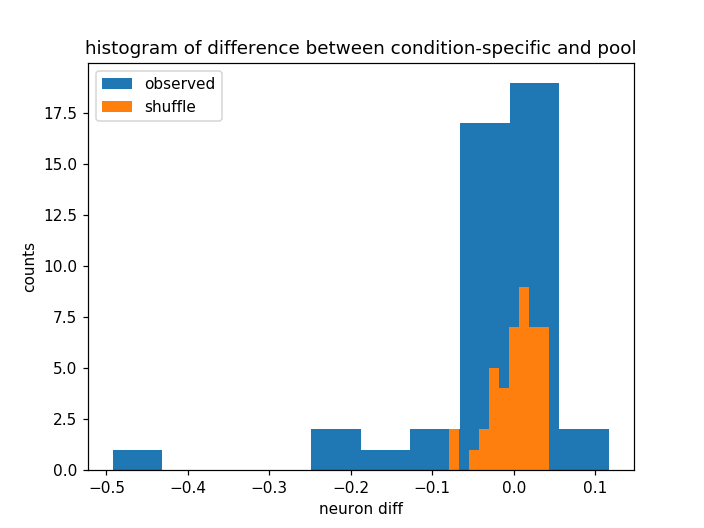

Text(0.5,1,'histogram of difference between condition-specific and pool')

In [569]:
plt.figure()
plt.hist(diff_cond, label='observed')
plt.hist(diff_sel, label='shuffle')
plt.legend()
plt.xlabel('neuron diff')
plt.ylabel('counts')
plt.title('histogram of difference between condition-specific and pool')

<IPython.core.display.Javascript object>


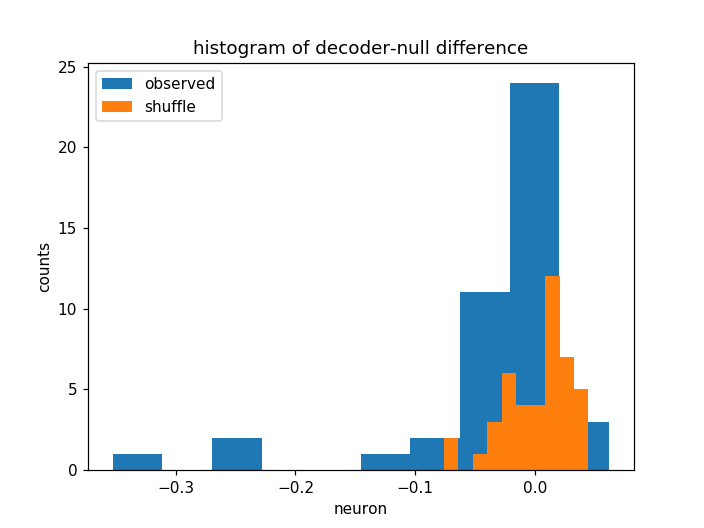

Text(0.5,1,'histogram of decoder-null difference')

In [570]:
plt.figure()
plt.hist(diff_null_cond, label='observed')
plt.hist(diff_null_sel, label='shuffle')
plt.legend()
plt.xlabel('neuron')
plt.ylabel('counts')
plt.title('histogram of decoder-null difference')

In [542]:
dist_sel = np.linalg.norm(diff_sel)
dist_sel

0.4853073317431461

In [543]:
dist_cond = nc[m, target, task_rot, 'n', 'dist', 'full'] 
dist_cond

0.6073976865976076